# Agente ReAct: Análisis Cinematográfico

**Análisis Profesional de Arquitectura ReAct aplicada al Cine**

Este notebook demuestra la implementación de un agente ReAct especializado en análisis cinematográfico con:
- Herramientas personalizadas para análisis de películas
- Visualizaciones de grafos de ejecución
- Casos de uso complejos
- Métricas de rendimiento

---

In [7]:
# Importaciones principales
import sys
from pathlib import Path
import json
import time
from datetime import datetime
from typing import Dict, List, Optional, Any
import os
from dotenv import load_dotenv
import asyncio

# Cargar variables de entorno
env_path = Path.cwd().parent / '.env'
load_dotenv(env_path)

# Agregar proyecto al path
sys.path.insert(0, str(Path.cwd().parent))

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from IPython.display import display, Markdown, Image

# Importaciones del proyecto
from src.agents.agent_factory import AgentFactory
from src.agents.agent_executor import AgentExecutor
from src.config import config
from langchain_core.tools import tool

# Estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("[OK] Importaciones cargadas")
print(f"[OK] API Key: {bool(config.openai_api_key)}")

[OK] Importaciones cargadas
[OK] API Key: True


## 1. Base de Datos de Películas Clásicas

Base de datos curada con información detallada sobre películas clásicas.

In [8]:
# Base de datos de películas clásicas
CINEMA_DATABASE = [
    {
        "id": 1,
        "title": "2001: A Space Odyssey",
        "director": "Stanley Kubrick",
        "year": 1968,
        "genres": ["Ciencia Ficción", "Drama"],
        "themes": ["Evolución humana", "Inteligencia artificial", "Existencialismo"],
        "symbolism": "El monolito representa el conocimiento y la evolución.",
        "rating": 8.3
    },
    {
        "id": 2,
        "title": "The Shining",
        "director": "Stanley Kubrick",
        "year": 1980,
        "genres": ["Terror", "Psicológico"],
        "themes": ["Aislamiento", "Locura", "Violencia doméstica"],
        "symbolism": "El hotel representa el pasado oscuro.",
        "rating": 8.4
    },
    {
        "id": 3,
        "title": "Inception",
        "director": "Christopher Nolan",
        "year": 2010,
        "genres": ["Ciencia Ficción", "Thriller"],
        "themes": ["Realidad vs sueños", "Culpa y pérdida", "Subconsciencia"],
        "symbolism": "El tótem representa la búsqueda de verdad.",
        "rating": 8.8
    },
    {
        "id": 4,
        "title": "The Dark Knight",
        "director": "Christopher Nolan",
        "year": 2008,
        "genres": ["Acción", "Crimen", "Drama"],
        "themes": ["Caos vs orden", "Dualidad", "Heroísmo"],
        "symbolism": "El Joker representa el caos anarquista.",
        "rating": 9.0
    },
    {
        "id": 5,
        "title": "Pulp Fiction",
        "director": "Quentin Tarantino",
        "year": 1994,
        "genres": ["Crimen", "Drama"],
        "themes": ["Redención", "Violencia", "Destino vs libre albedrío"],
        "symbolism": "El maletín representa lo inalcanzable.",
        "rating": 8.9
    }
]

print(f"[OK] Base de datos: {len(CINEMA_DATABASE)} películas")

[OK] Base de datos: 5 películas


## 2. Herramientas Cinematográficas

Tres herramientas especializadas para análisis de cine.

In [9]:
@tool
def cinema_database_search(query: str) -> str:
    """Busca películas por director, género, tema o título en la base de datos de cine."""
    query_lower = query.lower()
    results = []
    
    for movie in CINEMA_DATABASE:
        match = False
        
        if movie['director'].lower() in query_lower:
            match = True
        if any(genre.lower() in query_lower for genre in movie['genres']):
            match = True
        if any(theme.lower() in query_lower for theme in movie['themes']):
            match = True
        if movie['title'].lower() in query_lower:
            match = True
        
        if match:
            results.append(movie)
    
    if not results:
        return "No se encontraron películas."
    
    output = f"Se encontraron {len(results)} película(s):\n\n"
    for movie in results:
        output += f"{movie['title']} ({movie['year']})\n"
        output += f"  Director: {movie['director']}\n"
        output += f"  Géneros: {', '.join(movie['genres'])}\n"
        output += f"  Rating: {movie['rating']}/10\n\n"
    
    return output


@tool
def thematic_analysis(movie_title: str) -> str:
    """Análisis profundo de temas y simbolismo de una película específica."""
    movie = None
    for m in CINEMA_DATABASE:
        if movie_title.lower() in m['title'].lower():
            movie = m
            break
    
    if not movie:
        return f"No se encontró la película '{movie_title}'."
    
    analysis = f"ANÁLISIS: {movie['title']} ({movie['year']})\n"
    analysis += f"Director: {movie['director']}\n\n"
    analysis += f"TEMAS:\n"
    for i, theme in enumerate(movie['themes'], 1):
        analysis += f"  {i}. {theme}\n"
    analysis += f"\nSIMBOLISMO: {movie['symbolism']}\n"
    
    return analysis


@tool
def director_style_comparison(director_name: str) -> str:
    """Analiza el estilo de un director comparando sus películas."""
    director_movies = [m for m in CINEMA_DATABASE if director_name.lower() in m['director'].lower()]
    
    if not director_movies:
        return f"No se encontraron películas del director '{director_name}'."
    
    analysis = f"ANÁLISIS: {director_movies[0]['director']}\n"
    analysis += f"Películas: {len(director_movies)}\n\n"
    
    for movie in sorted(director_movies, key=lambda x: x['year']):
        analysis += f"  {movie['title']} ({movie['year']}) - {movie['rating']}/10\n"
    
    avg_rating = sum(m['rating'] for m in director_movies) / len(director_movies)
    analysis += f"\nRating promedio: {avg_rating:.2f}/10\n"
    
    return analysis


# Crear lista de herramientas
cinema_tools = [cinema_database_search, thematic_analysis, director_style_comparison]

## 3. Inicializar Agente ReAct

In [10]:
# Crear factory y agente con herramientas de cine
factory = AgentFactory()
model_name = "gpt-4o-mini"

# Crear agente ReAct con herramientas personalizadas
agent = factory.create_agent(model_name, agent_type='react', custom_tools=cinema_tools)
executor = AgentExecutor(agent, model_name)

print(f"[OK] Agente inicializado - Modelo: {model_name} - Herramientas: {len(cinema_tools)}")

[OK] Agente inicializado - Modelo: gpt-4o-mini - Herramientas: 3


[OK] Agente LangGraph creado - Tipo: StateGraph - Herramientas: 3

[VISUALIZACIÓN] Arquitectura del Agente ReAct con LangGraph


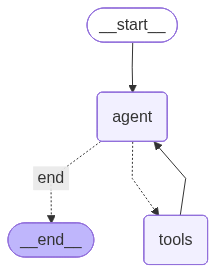


 Diagrama generado exitosamente

Este diagrama muestra:
  • START: Punto de inicio
  • agent: Nodo de razonamiento (LLM)
  • tools: Nodo de ejecución de herramientas
  • END: Punto final

Flujo: START → agent → [tools → agent]* → END


In [14]:
# Crear agente LangGraph ReAct para visualización de arquitectura
langgraph_agent = factory.create_agent(model_name, agent_type='langgraph_react', custom_tools=cinema_tools)

print(f"[OK] Agente LangGraph creado - Tipo: StateGraph - Herramientas: {len(cinema_tools)}")
print("\n[VISUALIZACIÓN] Arquitectura del Agente ReAct con LangGraph")
print("="*80)

# Generar y mostrar el diagrama Mermaid del grafo
try:
    graph_image = langgraph_agent.get_graph().draw_mermaid_png()
    display(Image(graph_image))

    print("\n Diagrama generado exitosamente")
    print("\nEste diagrama muestra:")
    print("  • START: Punto de inicio")
    print("  • agent: Nodo de razonamiento (LLM)")
    print("  • tools: Nodo de ejecución de herramientas")
    print("  • END: Punto final")
    print("\nFlujo: START → agent → [tools → agent]* → END")
except Exception as e:
    print(f"[ERROR] No se pudo generar el diagrama: {e}")
    import traceback
    traceback.print_exc()

## 3.5 Visualización de Arquitectura con LangGraph

LangGraph permite visualizar la estructura del agente como un grafo de estado, mostrando:
- Nodos: agent (razonamiento), tools (ejecución)
- Edges: Flujo de control entre nodos
- Decisiones condicionales: Cuándo continuar o terminar

## 4. Funciones de Visualización

In [12]:
def visualize_reasoning_trace(trace, title="Grafo de Ejecución ReAct"):
    """Visualiza el trace de razonamiento."""
    G = nx.DiGraph()
    
    colors = {
        'query': '#FF1493',
        'thought': '#4169E1',
        'action': '#32CD32',
        'observation': '#FFA500',
        'answer': '#9370DB'
    }
    
    node_colors = []
    node_sizes = []
    labels = {}
    
    G.add_node(0)
    node_colors.append(colors['query'])
    node_sizes.append(3000)
    labels[0] = "Consulta"
    
    prev_node = 0
    node_id = 1
    
    for step in trace:
        step_type = step.get('type', '')
        
        if step_type in ['thought', 'action', 'observation']:
            G.add_node(node_id)
            G.add_edge(prev_node, node_id)
            
            if step_type == 'action':
                node_colors.append(colors['action'])
                node_sizes.append(2500)
                tool = step.get('tool', 'desconocido')
                labels[node_id] = f"Acción\n{tool}"
            elif step_type == 'observation':
                node_colors.append(colors['observation'])
                node_sizes.append(2500)
                labels[node_id] = "Observación"
            else:
                node_colors.append(colors['thought'])
                node_sizes.append(2000)
                labels[node_id] = "Pensamiento"
            
            prev_node = node_id
            node_id += 1
    
    G.add_node(node_id)
    G.add_edge(prev_node, node_id)
    node_colors.append(colors['answer'])
    node_sizes.append(3000)
    labels[node_id] = "Respuesta"
    
    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                          alpha=0.9, edgecolors='black', linewidths=2)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True,
                          arrowsize=25, arrowstyle='->', width=2.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G


def display_result_summary(result, query_name):
    """Muestra un resumen del resultado."""
    print(f"\n{'='*100}")
    print(f"[CASO] {query_name}")
    print("="*100)
    print(f"\n{result['answer']}\n")
    print("─"*100)
    
    metrics = result["metrics"]
    print(f"\n[MÉTRICAS] Tiempo: {metrics['execution_time_seconds']:.2f}s | "
          f"Tokens: {metrics['estimated_tokens']['total']:,} | "
          f"Costo: ${metrics['estimated_cost_usd']:.6f} | "
          f"Pasos: {metrics['num_steps']}")
    print("="*100)

## 5. Caso 1: Análisis de Director - Kubrick

In [ ]:
query1 = "Analiza las películas de Stanley Kubrick"

# FIX: Use await directly in Jupyter
result1 = await executor.execute(query1)
display_result_summary(result1, "Análisis de Kubrick")
visualize_reasoning_trace(result1["reasoning_trace"], "ReAct: Análisis de Kubrick")

## 6. Caso 2: Análisis Temático - Inception

In [ ]:
query2 = "Explica los temas de Inception"

# FIX: Use await directly in Jupyter
result2 = await executor.execute(query2)
display_result_summary(result2, "Análisis de Inception")
visualize_reasoning_trace(result2["reasoning_trace"], "ReAct: Análisis de Inception")

## 7. Caso 3: Comparación de Directores

In [ ]:
query3 = "Compara Kubrick con Nolan"

# FIX: Use await directly in Jupyter
result3 = await executor.execute(query3)
display_result_summary(result3, "Comparación Kubrick vs Nolan")
visualize_reasoning_trace(result3["reasoning_trace"], "ReAct: Comparación")

## 8. Análisis Comparativo

In [ ]:
print("="*100)
print("[LANGGRAPH DEV] Servidor de Desarrollo LangGraph - Cinema Agent")
print("="*100)

print("\nEl servidor de desarrollo LangGraph permite:")
print("  • Visualización interactiva del grafo en tiempo real")
print("  • Debugging paso a paso de la ejecución del agente")
print("  • Inspección de estado en cada nodo")
print("  • Timeline de ejecución")

print("\n[INSTRUCCIONES] Para iniciar el servidor:")
print("="*100)

print("\n1. En una terminal, navega al directorio del proyecto:")
print("   cd /Users/carlosdaniel/Desktop/henry_clase_demo")

print("\n2. Inicia el servidor LangGraph para Cinema Agent (puerto 8124):")
print("   langgraph dev --port 8124")

print("\n3. Abre tu navegador en:")
print("   http://localhost:8124")

print("\n[NOTA] Para el notebook de ReAct, usa el puerto 8123")
print("="*100)

## 10. Integración con LangGraph Dev Server

El servidor de desarrollo LangGraph permite visualización interactiva y debugging paso a paso.

In [ ]:
all_results = [result1, result2, result3]
case_names = ["Kubrick", "Inception", "Comparación"]

comparison_df = pd.DataFrame({
    'Caso': case_names,
    'Tiempo (s)': [r['metrics']['execution_time_seconds'] for r in all_results],
    'Pasos': [r['metrics']['num_steps'] for r in all_results],
    'Tokens': [r['metrics']['estimated_tokens']['total'] for r in all_results],
    'Costo ($)': [r['metrics']['estimated_cost_usd'] for r in all_results]
})

print("\n[COMPARACIÓN] Rendimiento")
print("="*100)
display(comparison_df)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(case_names, comparison_df['Tiempo (s)'], color='#FF6B6B', alpha=0.8)
axes[0, 0].set_xlabel('Segundos')
axes[0, 0].set_title('Tiempo de Ejecución', fontweight='bold')
axes[0, 0].invert_yaxis()

axes[0, 1].barh(case_names, comparison_df['Pasos'], color='#4ECDC4', alpha=0.8)
axes[0, 1].set_xlabel('Pasos')
axes[0, 1].set_title('Complejidad', fontweight='bold')
axes[0, 1].invert_yaxis()

axes[1, 0].barh(case_names, comparison_df['Tokens'], color='#95E1D3', alpha=0.8)
axes[1, 0].set_xlabel('Tokens')
axes[1, 0].set_title('Uso de Tokens', fontweight='bold')
axes[1, 0].invert_yaxis()

axes[1, 1].barh(case_names, comparison_df['Costo ($)'], color='#AA96DA', alpha=0.8)
axes[1, 1].set_xlabel('USD')
axes[1, 1].set_title('Costo', fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nPromedio - Tiempo: {comparison_df['Tiempo (s)'].mean():.2f}s | "
      f"Pasos: {comparison_df['Pasos'].mean():.1f} | "
      f"Tokens: {comparison_df['Tokens'].mean():.0f} | "
      f"Costo: ${comparison_df['Costo ($)'].mean():.6f}")

## 9. Conclusiones

Este notebook demuestra la implementación de un agente ReAct especializado en análisis cinematográfico con herramientas personalizadas.

### Características:
- Herramientas especializadas para búsqueda, análisis temático y comparación de directores
- Visualización de grafos de ejecución
- Métricas de rendimiento detalladas

### Aplicaciones:
- Educación en análisis cinematográfico
- Investigación de estilos de directores
- Recomendaciones inteligentes

---

**Referencias:**
- ReAct Paper: https://arxiv.org/abs/2210.03629
- LangChain: https://python.langchain.com/